In [1]:
from dask.distributed import Client, LocalCluster
# import geopandas as gpd
# import networkx as nx
# from itertools import combinations
import dask
import numpy as np
from dask import delayed, dataframe as dd
import dask.array as da
import bokeh
import geopandas as gpd
from dask_ml.cluster import KMeans
import dask_geopandas as dgpd
from tqdm.notebook import tqdm
import pandas as pd
from shapely import Polygon
import json
import os
import glob
import matplotlib.pyplot as plt

/tmp/ipykernel_7793/2598064629.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
tessellation = gpd.read_parquet("./out/singapore/tessellation.pq")

In [3]:
# Check for duplicates in the 'uID' column
duplicates = tessellation[tessellation.duplicated(subset=['uID'])].dropna(subset=['uID'])

if duplicates.empty:
    print("No duplicates found")
else:
    print("Duplicates found:")
    print(duplicates)

No duplicates found


<Axes: >

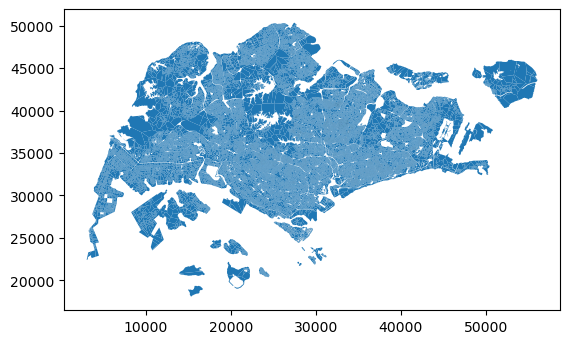

In [4]:
tessellation.plot()

In [5]:
# Init graph object
# G = nx.Graph()

In [6]:
# uID_list = tessellation["uID"].unique()

# for uid in np.sort(uID_list):
#     G.add_node(uid)

In [7]:
# Load the tessellation as a Dask dataframe
# tessellation_dd = dd.from_pandas(tessellation, npartitions=24)

In [8]:
# # define a function to process every pair
# def process_pair(pair):
#     # do something with the pair of rows

#     out = (int(pair[0]["uID"]), int(pair[1]["uID"]))
#     print(out)
#     return out
#     # if x_geom.touches(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])
#     # elif x_geom.intersects(y_geom):
#     #     G.add_edge(pair[0]["uID"], pair[1]["uID"])

# pairs = []

# # iterate through every pair of rows in the Dask dataframe
# pairs = tessellation_dd.compute().index.tolist()
# for i, j in combinations(pairs, 2):
#     # get the rows of the two indices
#     row1 = tessellation_dd.loc[i].compute()
#     row2 = tessellation_dd.loc[j].compute()

#     # do something with the pair of geometries
#     pair = process_pair((row1, row2))
    
#     # append the pair to the list
#     pairs.append(pair)

In [9]:
Daskcluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(Daskcluster)
client

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39809 instead
  warnings.warn(
2023-04-18 10:05:43,517 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 10:05:43,519 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 10:05:43,521 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 10:05:43,524 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 10:05:43,528 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2023-04-18 10:05:43,531 - distributed.nanny.memory - WARNING - Ignoring

<Client: 'tcp://127.0.0.1:35055' processes=8 threads=16, memory=250.47 GiB>

In [10]:
tessellation = tessellation.reset_index(drop=True)

In [11]:
tessellation

uID                                           geometry   eID
0      73486.0  POLYGON ((42345.292 33839.768, 42345.607 33840...     5
1      74358.0  MULTIPOLYGON (((42674.008 33576.904, 42677.423...     5
2      73497.0  MULTIPOLYGON (((42401.927 33851.152, 42401.606...     5
3      73508.0  POLYGON ((42205.213 33723.253, 42205.300 33724...     5
4      73502.0  MULTIPOLYGON (((42113.540 33900.420, 42113.248...     5
...        ...                                                ...   ...
76492  73534.0  POLYGON ((41903.215 35303.442, 41914.367 35295...  2839
76493  74471.0  POLYGON ((42502.870 37070.330, 42522.949 37069...   473
76494  75817.0  POLYGON ((44572.445 35487.575, 44678.812 35737...    30
76495  75833.0  MULTIPOLYGON (((45462.523 38178.956, 45451.205...    30
76496  75848.0  POLYGON ((45268.528 37964.116, 45258.200 37951...    30

[76497 rows x 3 columns]

In [12]:
# Assuming 'tessellation' is a GeoDataFrame with a 'geometry' column
# Convert the GeoDataFrame to a Dask GeoDataFrame
dask_tessellation = dd.from_pandas(tessellation, npartitions=16)

In [13]:
x_coords = dask_tessellation.geometry.centroid.x.to_dask_array(lengths=True)
y_coords = dask_tessellation.geometry.centroid.y.to_dask_array(lengths=True)

# Concatenate x and y coordinates along the second axis
coords = da.concatenate([x_coords[:, None], y_coords[:, None]], axis=1)

# Rechunk the coords array along the first axis only
coords = coords.rechunk({0: -1, 1: coords.shape[1]})

coords.compute()

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 412.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:94: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/lates

array([[42428.49413674, 33521.08512412],
       [42965.18954383, 33828.50904263],
       [42545.9651526 , 33777.13421521],
       ...,
       [44735.53290797, 35597.80872108],
       [45273.73627276, 37648.23064449],
       [45248.43403053, 37968.16843103]])

In [14]:
n_clusters = int(len(tessellation) / 11000) # compute the number of clusters needed
print(n_clusters)

6


In [15]:
# Train the KMeans estimator with 100 clusters
kmeans = KMeans(n_clusters)

# Fit the KMeans estimator to the data
kmeans.fit(coords)

# Predict the clusters of the data points
labels = kmeans.predict(coords)

labels_np = labels.compute()

tessellation["cluster"] = labels_np

/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 412.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 412.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 412.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 412.92 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/virgilxw/miniconda3/lib/python

<Axes: >

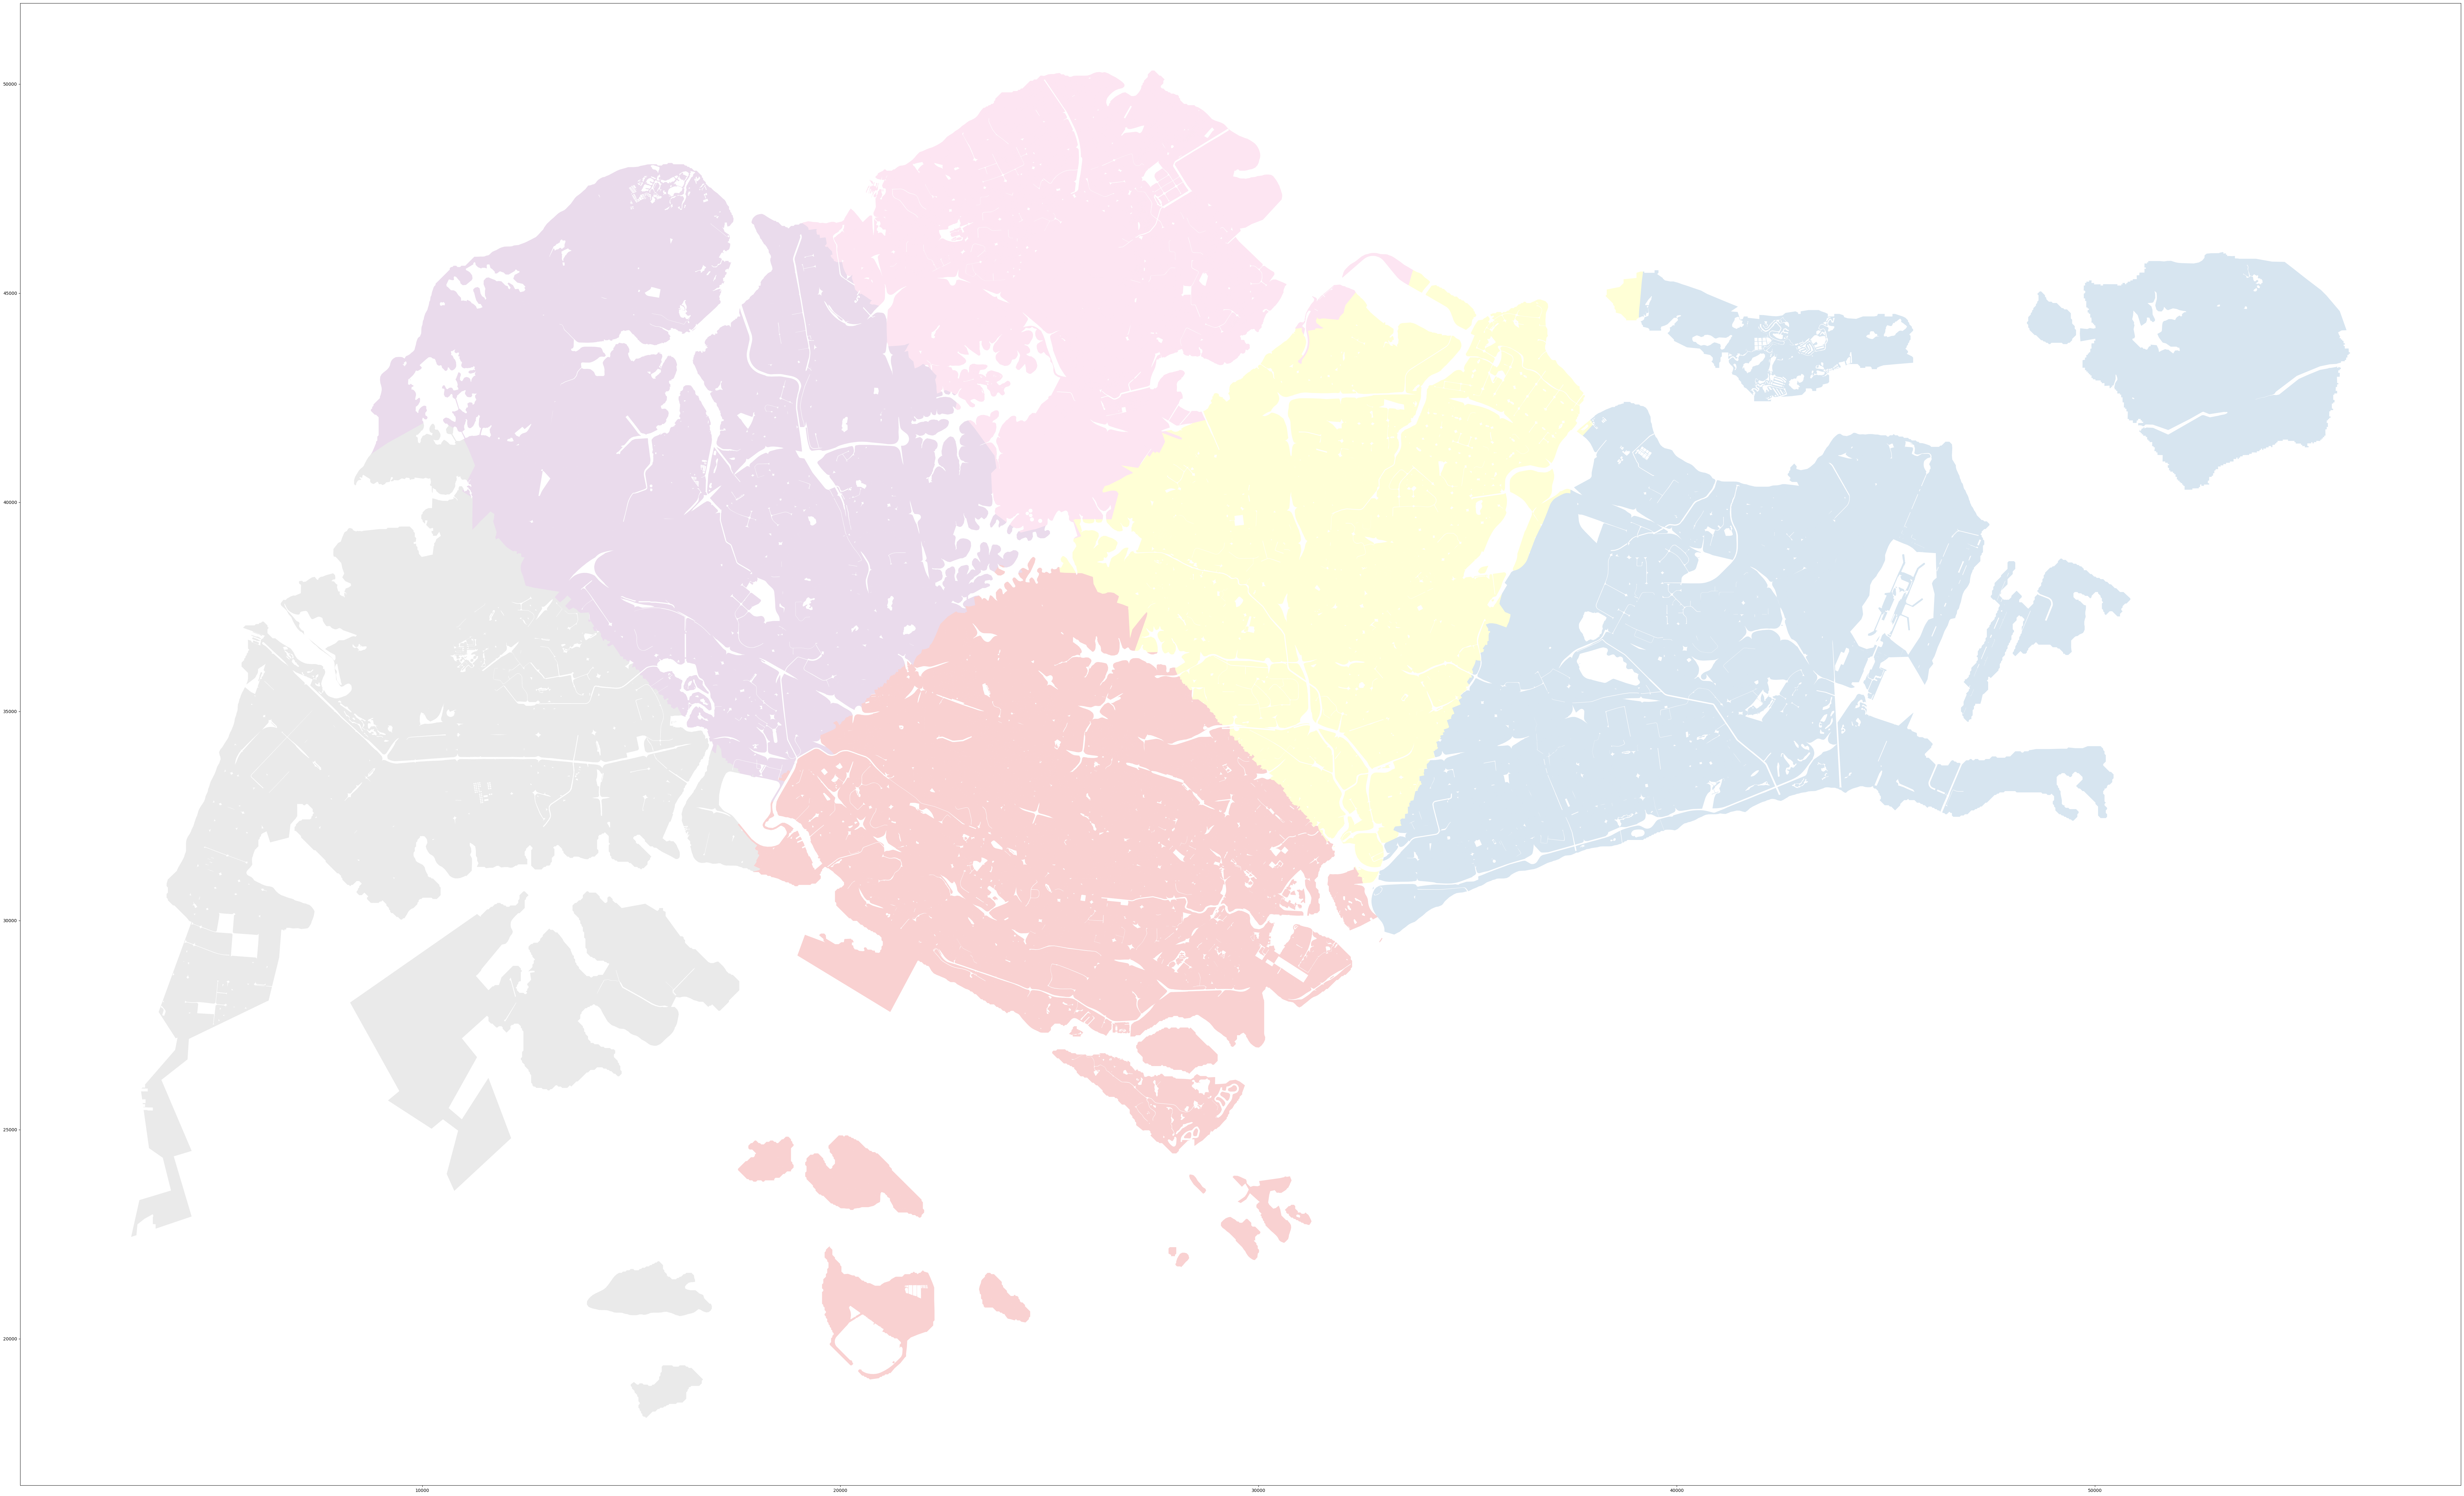

In [16]:
# Specify the column to use for color and colormap
column = 'cluster'
cmap = 'Set1'

# Plot the GeoDataFrame with colors determined by the 'cluster' column
tessellation.plot(column=column, cmap=cmap, figsize=(100, 100), alpha=0.2)

In [17]:
# Assume `gdf` is a GeoDataFrame
tessellation_grouped = tessellation.groupby('cluster')
cluster_list = [cluster for cluster in tessellation_grouped]

No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found
No duplicates found


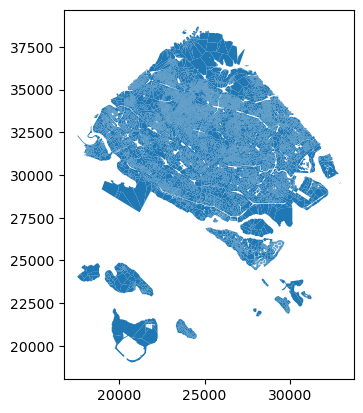

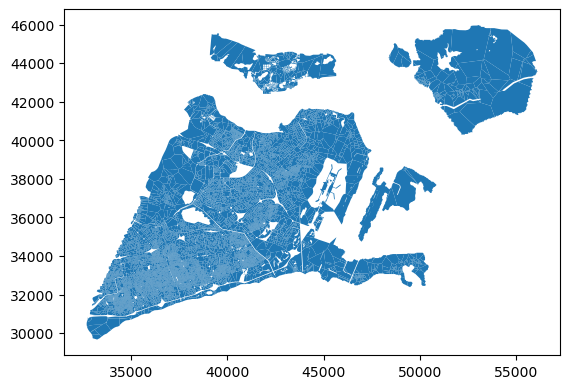

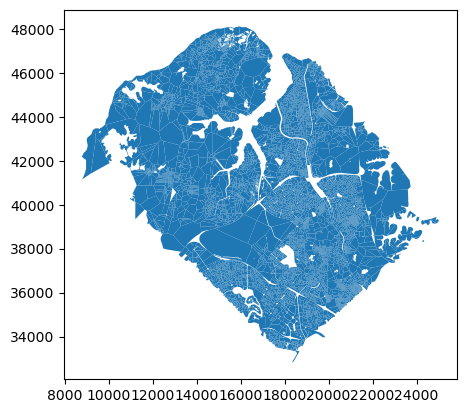

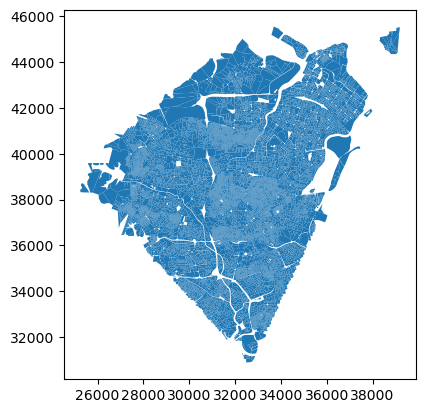

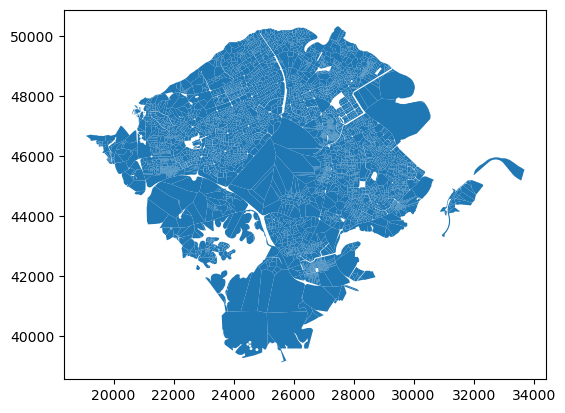

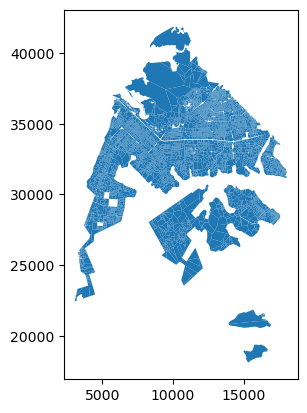

In [18]:
for index, gdf in cluster_list:
    # Check for duplicates in the 'uID' column
    duplicates = gdf[gdf.duplicated(subset=['uID'])].dropna(subset=['uID'])

    if duplicates.empty:
        print("No duplicates found")
    else:
        print("Duplicates found:")
        print(duplicates)
    gdf.plot()

In [19]:
Daskcluster.close()
client.shutdown()

In [20]:
cluster = tessellation.dissolve(by="cluster")
cluster.to_parquet("./out/singapore/cluster_dissolved.pq")

In [21]:
file_pattern = "./out/singapore/tess_cells_in_cluster_*.pq"
file_list = glob.glob(file_pattern)

for file_path in file_list:
    if os.path.exists(file_path):
        os.remove(file_path)

for index, cluster in cluster_list:
    cluster.to_parquet(f"./out/singapore/tess_cells_in_cluster_{index}.pq")

In [22]:
includes_dict = dict()
for i in range(n_clusters):
    includes_dict[i] = []

for index, row in tqdm(tessellation.iterrows(), total=tessellation.shape[0]):
    
    includes_dict[row["cluster"]].append(row["uID"])

file_path = "./out/singapore/what_cells_are_in_what_cluster_dict.json"

if os.path.exists(file_path):
    os.remove(file_path)

with open(file_path, 'x') as f:
    json.dump(includes_dict, f)

  0%|          | 0/76497 [00:00<?, ?it/s]

In [23]:
tessellation.to_parquet(f"./out/singapore/tessellation.pq")